## Diffusion Limited Aggregation

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time

### SOR solver

In [120]:
def SOR_solver(i, j, n_i, c_k, c_k_1, w=1.8):

    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]

    return c_new

In [211]:
def growth_candi_generator(obj_old):
    # create a blank growth candidate set
    candidates = set()

    obj_inter = obj_old.copy()

    # generate the growth candidates
    for (i, j)  in obj_old:

        if i == 0:
            g_i1, g_j1, g_j0 = (i+1, j), (i, j+1), (i, j-1)
            obj_inter.update([g_i1, g_j1, g_j0])
        if j == 0:
            g_i1, g_i0, g_j1 = (i+1, j), (i-1, j), (i, j+1)
            obj_inter.update([g_i1, g_i0, g_j1])
        if i > 0 and j > 0:
            g_i1, g_i0, g_j1, g_j0 = (i+1, j), (i-1, j), (i, j+1), (i, j-1)
            
            # update the neighbouring growth candidate
            obj_inter.update([g_i1, g_i0, g_j1, g_j0])

        # check if the growth candidates are in the cluster, 
        # and pick the ones that are not in the old object
        growth_candi = obj_inter - obj_old

        # Add the growth candidate to the memory
        candidates.update(growth_candi)
    
    # return all the growth candidates
    return candidates

In [214]:
def growth_candi_selector(c_s, n, candi_all):
    
    # calculate the sum of c_candidate
    p_c = 0
    c_store = []

    candi_all = list(candi_all)

    for (i, j) in candi_all:
        # use try/except to skip growth candidates that are out of grid bounds
        try:
            c_candi = np.around(c_s[i, j], decimals=4)

            # Store the current c_candidate value
            c_store.append(c_candi)
            
        except:
            pass
    
    # print('\n')

    # calculate tbe probablity of each growth candidate
    p_c = np.array(c_store) ** n
    p_c = p_c / sum(p_c)

    # select the real growth candidate
    c_add = np.random.choice(c_store, size=1, p=p_c)
    candidate = candi_all[c_store.index(c_add)]

    return {candidate}

In [123]:
def object_detector(i, j, obj):

    passcheck = 0

    # check if the current lattice point is inside the dla object
    if (i, j) in obj:
        passcheck = 1

    return passcheck

In [317]:
def DLA_sor(c_sol, obj, max_ite=5000, w=1.8, e=1e-5, N=50):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    ###########################################################
    # Create tracker matrix
    # c_store_s = np.zeros((max_ite+1, N, N))
    # c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    # delta_s = np.zeros(max_ite+1)

    # set the object calue to 0
    for (i, j) in obj:
        # skip the ones that are out of bound
        try:
            c_sol[i, j] = 0
        except:
            print('out of bound!')
            pass

    # create matrix to store function value at the last step
    c_keep_s = np.copy(c_sol)

    # Create matrix to store function value at the current step
    c_s = c_sol
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i, j=j, obj=obj)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w)
                else:
                    c_s[i, j] = 0
                ####################################################################
        
        # Update the tracker
        # c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        # delta_s[k] = abs(max(diff_s.max(), diff_s.min(), key=abs))
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_s, k


In [323]:
def implement_dla(c_sol, obj_0, N, n, max_iteration=100, w=1.8):
    obj = obj_0
    k_all = 0

    # simulate the DLA
    for i in range(max_iteration):
        # compute the PDE solution with dla object 
        c_sol, k_single = DLA_sor(c_sol=c_sol, obj=obj, N=N, w=w)

        # calculate the sum of convergency step
        k_all += k_single

        # update the dla object
        growth_candis = growth_candi_generator(obj_old=obj)
        candidate = growth_candi_selector(c_s=c_sol, candi_all=growth_candis, n=n)
        obj.update(candidate)

        print(i, end=',')

    k_avg = k_all / max_iteration
    
    return c_sol, obj, k_avg

In [320]:
if __name__ == '__main__':
    # define the interval size we need
    N = 100

    # Start the simulation with the analytical solution
    c_0 = np.linspace(0, 1, N)
    c_analytic = np.tile(c_0, (N, 1))
    ite = 100

    # create the original dla object, it is a set!
    obj_origin = {(50, 0)}

    n_set = [0, 0.5, 1, 1.5, 2, 2.5]

    c_dla = np.zeros((len(n_set), N, N))
    obj_final = []
    k_store = []

    for i, n in enumerate(n_set):

        # check the time my programme takes
        start_time = time.time()

        print(n)
        c_dla_, obj_final_, k_avg = implement_dla(c_sol=c_analytic, obj_0=obj_origin, N=N, max_iteration=ite, n=n)
        c_dla[i] = c_dla_
        obj_final.append(list(obj_final_))
        k_store.append(k_avg)

        print("--- %s seconds ---" % (time.time() - start_time), '\n')


0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 32.67931032180786 seconds --- 

0.5
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 51.41650199890137 seconds --- 

1
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 77.33730173110962 seconds --- 

1.5
0,1,2,3,4,

In [322]:
k_store

[25.59, 41.14, 62.85, 69.25, 93.47, 71.99]

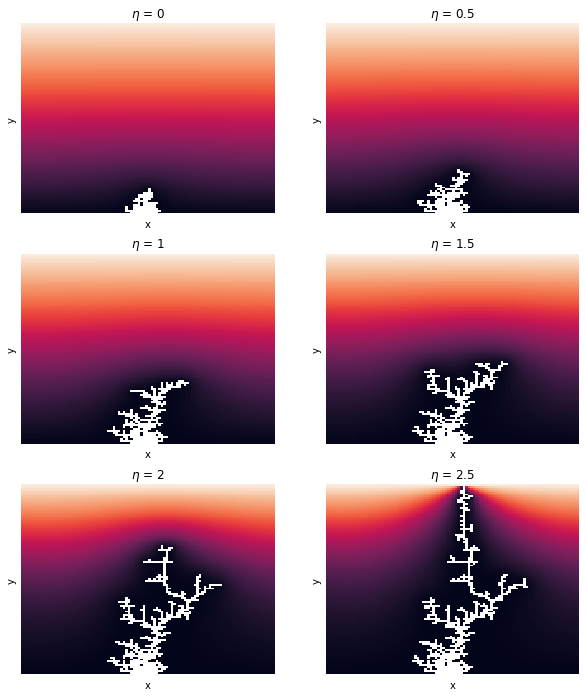

In [321]:
c_dla = np.array(c_dla)

fig1, ax1 = plt.subplots(nrows=3, ncols=2)

plt.rcParams['figure.figsize'] = (10, 12)

sns.heatmap(np.flipud(c_dla[0].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[0].T)==0, ax=ax1[0][0])
ax1[0][0].set(xlabel='x', ylabel='y', title=r'$\eta$ = 0')
sns.heatmap(np.flipud(c_dla[1].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[1].T)==0, ax=ax1[0][1])
ax1[0][1].set(xlabel='x', ylabel='y', title=r'$\eta$ = 0.5')
sns.heatmap(np.flipud(c_dla[2].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[2].T)==0, ax=ax1[1][0])
ax1[1][0].set(xlabel='x', ylabel='y', title=r'$\eta$ = 1')
sns.heatmap(np.flipud(c_dla[3].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[3].T)==0, ax=ax1[1][1])
ax1[1][1].set(xlabel='x', ylabel='y', title=r'$\eta$ = 1.5')
sns.heatmap(np.flipud(c_dla[4].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[4].T)==0, ax=ax1[2][0])
ax1[2][0].set(xlabel='x', ylabel='y', title=r'$\eta$ = 2')
sns.heatmap(np.flipud(c_dla[5].T), cbar=False, xticklabels=False, yticklabels=False, mask=np.flipud(c_dla[5].T)==0, ax=ax1[2][1])
ax1[2][1].set(xlabel='x', ylabel='y', title=r'$\eta$ = 2.5')

plt.show()

Question: Maybe we can use the property of $\textbf{set}$ to reduce the time required to solve the diffusion equation?

In [362]:
if __name__ == '__main__':
    # define the interval size we need
    N = 100

    # Start the simulation with the analytical solution
    c_0 = np.linspace(0, 1, N)
    c_analytic = np.tile(c_0, (N, 1))
    ite = 100

    # create the original dla object, it is a set!
    obj_origin = {(50, 0)}

    n_set = [0, 0.5, 1, 1.5, 2, 2.5]

    c_dla_w = np.zeros((len(n_set), N, N))
    obj_final_w = []
    k_store_w = []

    for i, n in enumerate(n_set):

        # check the time my programme takes
        start_time = time.time()

        print(n)
        c_dla_, obj_final_, k_avg = implement_dla(c_sol=c_analytic, obj_0=obj_origin, N=N, max_iteration=ite, n=n, w=1.75)
        c_dla_w[i] = c_dla_
        obj_final_w.append(list(obj_final_))
        k_store_w.append(k_avg)

        print("--- %s seconds ---" % (time.time() - start_time), '\n')

0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 26.208006381988525 seconds --- 

0.5
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 42.07174897193909 seconds --- 

1
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,--- 54.830031633377075 seconds --- 

1.5
0,1,2,3,

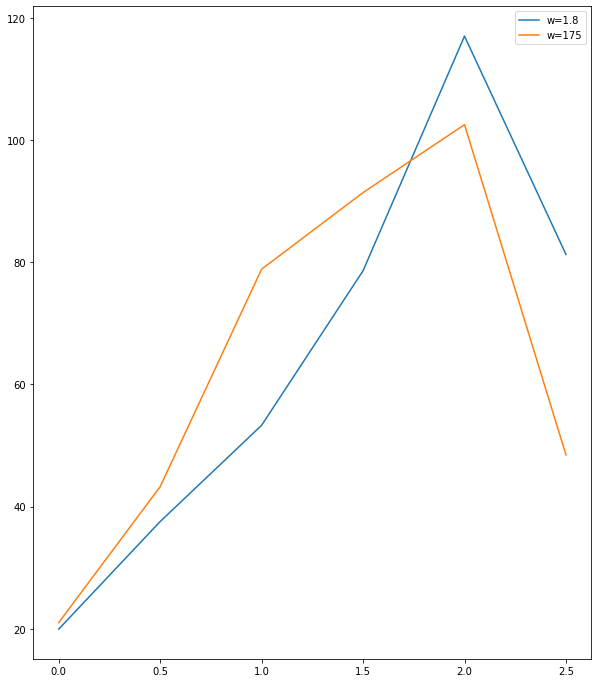

In [361]:
plt.plot(n_set, k_store, label='w=1.8')
plt.plot(n_set, k_store_w, label='w=175')
plt.legend()
plt.show()

### optimise SOR by setting $\omega$

## Accelerating the solving process by using numba and red-black ordering method

In [ ]:
from numba import jit, njit, vectorize, prange
import time

@vectorize
def sor_rb_solver(c_i_j, c_i_0, c_i_1, c_j_0, c_j_1, w=1.8):

    c_new = w/4 * (c_i_0 + c_i_1 + c_j_0 + c_j_1) + (1-w) * c_i_j

    return c_new

In [ ]:
# construct the red_black ordering grid
# Note that red block: odd & odd and even & even; black block: even & odd and odd & even

def red_black_grid(N):
    x = np.linspace(0, N-1, N, dtype=int)
    # Note that the index of y starts from j=1
    y = np.linspace(1, N-2, N-2, dtype=int)

    red_block = set()
    black_block = set()
    for p in prange(len(x)):
        i = x[p]
        for j in y:
            if ((i+j) % 2 == 1):
                red_block.update({(i, j)})
            else:
                black_block.update({(i, j)}) 

    red = list(red_block)
    black = list(black_block)

    # get the indices for red and black blocks
    red_indices = np.array(([i[0] for i in red], [i[1] for i in red]))
    black_indices = np.array(([i[0] for i in black], [i[1] for i in black]))

    return red_indices, black_indices

In [ ]:
def lattice_value_finder(c_n, b_ind, N):

    b_i0, b_i1, b_j0, b_j1 = np.array((b_ind[0]-1, b_ind[1])), np.array((b_ind[0]+1, b_ind[1])), \
        np.array((b_ind[0], b_ind[1]-1)), np.array((b_ind[0], b_ind[1]+1))
    
    '''
    Watch out here, might be wrong!
    '''
    # Adjust the block index for boundary conditions (periodic x)
    b_i0[b_i0 < 0] = N - 1
    b_i1[b_i1 >= N] = 0

    b_ind, b_i0, b_i1, b_j0, b_j1 = tuple(b_ind), tuple(b_i0), tuple(b_i1), tuple(b_j0), tuple(b_j1), 

    c, c_i0, c_i1, c_j0, c_j1 = c_n[b_ind], c_n[b_i0], c_n[b_i1], c_n[b_j0], c_n[b_j1]

    return c, c_i0, c_i1, c_j0, c_j1

In [ ]:
def get_c_next(c_n, red_indices, black_indices, N=100, w=1.8):

    c_n = np.copy(c_n)

    start_red_value_finder = time.time()

    # get the c value for red blocks
    c_red = lattice_value_finder(c_n=c_n, b_ind=red_indices, N=N)
    c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_redj1 = c_red[0], c_red[1], c_red[2], c_red[3], c_red[4]

    end_red_value_finder = time.time()
    value_finder_time = end_red_value_finder - start_red_value_finder

    start_calculation = time.time()

    # update all the c_n+1 value for red blocks
    c_n_red = sor_rb_solver(c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_redj1, 1.93)
    c_n[tuple(red_indices)] = c_n_red

    end_calculation = time.time()

    calculation_time = end_calculation - start_calculation

    # get the c value for black blocks
    c_black = lattice_value_finder(c_n=c_n, b_ind=black_indices, N=N)
    c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1 = c_black[0], c_black[1], c_black[2], c_black[3], c_black[4]
    
    # update all the c_n+1 value for black blocks
    c_n_black = sor_rb_solver(c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1, w)
    c_n[tuple(black_indices)] = c_n_black
    
    # return the c_next matrix
    return c_n, value_finder_time, calculation_time

In [ ]:
%%time
if __name__ == '__main__':
    # Define parameters
    N = 150
    w = 1.8
    e = 1e-5

    # start from rest
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)

    time_grid_generate = 0
    value_finder_time = 0
    calculation_time = 0

    # Generate red_black_grid
    start_grid = time.time()
    red, black = red_black_grid(N)
    end_grid = time.time()
    
    time_grid_generate += (end_grid - start_grid)


    for k in range(2000):
        
        c_s_next, value_finder_t, calculation_t = get_c_next(c_n=c_s, red_indices=red, black_indices=black, N=N, w=w)

        value_finder_time += value_finder_time
        calculation_time += calculation_t

        # apply the threshold
        diff_s = c_s_next - c_s
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_s = np.copy(c_s_next)
        
        if k % 200 == 0:
            print(k, end=',')

0,200,400,600,800,1000,1200,1400,1600,Wall time: 1.95 s


In [ ]:
print( time_grid_generate, value_finder_time, calculation_time)

0.015003204345703125 0 0.18203353881835938
